<a href="https://colab.research.google.com/github/AugustWinderickx/Applied_Multivariate_Statistical_Analysis/blob/main/Copy_of_topological_data_analysis_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topological Data Analysis

In this tutorial you will learn how to apply common topological data analysis (TDA) tools for explorating high-dimensional data. TDA has many uses within data analysis. We will focus on exploration, which is particularly powerful when combined with interactive visualizations. TDA can also be used for feature extraction (i.e., summarize complex data by their topological features), guide feature selection for machine learning (i.e., determine which features distinguish sub-populations within the data), and model interpretation (i.e., investigate how a model treats different aspects of the input-space).

## Practical matters

To run this notebook, either on Google Colaborate or locally, you will have to install several packages. Run the code cells in this section and make sure to restart the kernel when asked. This may take a couple of minutes...

In [1]:
%conda install giotto-tda multi-mst returns

/home/august-winderickx/miniconda3/lib/python3.12/site-packages/conda/base/context.py:198: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
/home/august-winderickx/miniconda3/lib/python3.12/site-packages/conda/base/context.py:198: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stab

### Imports

General imports, don't forget to evaluate this cell :) Also: this may take a while.

If this crashes, comment the lines with `multi_mst`. We will then have to skip that specific exercise towards the end of the notebook.

In [1]:
import pandas as pd
import numpy as np
from multi_mst.k_mst_descent import KMSTDescent
from multi_mst.noisy_mst import NoisyMST
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from returns.pipeline import flow
import random
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

/home/august-winderickx/miniconda3/envs/DR/lib/python3.11/site-packages/umap/umap_.py:2021: UserWarning: precomputed_knn[2] (knn_search_index) is not an NNDescent object: transforming new data with transform will be unavailable.
  warn(
/home/august-winderickx/miniconda3/envs/DR/lib/python3.11/site-packages/umap/umap_.py:2021: UserWarning: precomputed_knn[2] (knn_search_index) is not an NNDescent object: transforming new data with transform will be unavailable.
  warn(
/home/august-winderickx/miniconda3/envs/DR/lib/python3.11/site-packages/umap/umap_.py:2021: UserWarning: precomputed_knn[2] (knn_search_index) is not an NNDescent object: transforming new data with transform will be unavailable.
  warn(


### The data
We will use two small datasets to play with. One is a point-cloud of a horse, and the other is the dataset used in the lecture.

#### The horse

In [2]:
horse_data = pd.read_csv("http://aida-lab.be/assets/horse.csv")

# We have to take a subsample of the data, otherwise the networkx plotting crashes...
# Comment this line if you want to export to CSV and load in gephi.
horse_data = horse_data.sample(n=2000, random_state=42)

# We'll also add an `id` column to each row which we'll need later.
horse_data['id'] = range(0, len(horse_data))

In [3]:
horse_data

,x,y,z,id
3715,-0.010630,0.844801,0.467552,0
3574,-0.024072,0.810356,0.472199,1
8228,-0.001802,0.264261,-0.505758,2
3524,-0.032098,0.761185,0.315659,3
2988,0.002864,0.725523,0.160297,4
...,...,...,...,...
3395,-0.030961,0.848987,0.344090,1995
4505,0.015799,0.842914,0.450852,1996
7868,-0.018455,0.531450,-0.468756,1997
3541,-0.033572,0.856855,0.286055,1998


<Axes: xlabel='x', ylabel='y'>

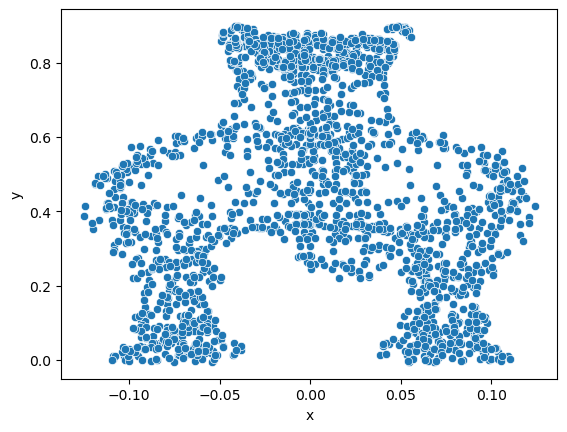

In [4]:
sns.scatterplot(horse_data,x="x",y="y")

<Axes: xlabel='z', ylabel='y'>

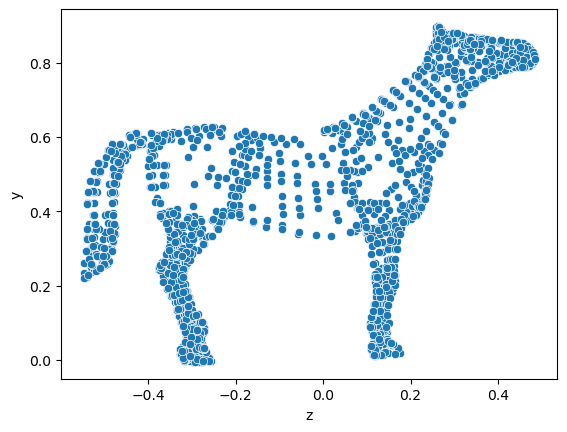

In [5]:
sns.scatterplot(horse_data,x="z",y="y")

So apparently:
* `x` is left-right
* `y` is bottom-top
* `z` is back-front

#### The circle(s)
You will recognise this data from the lecture, but not right away...

In this case, the graph was already created beforehand, but we will first plot some of the features.

In [6]:
circles_data = pd.read_csv("http://aida-lab.be/assets/circles.csv")

circles_data

,x,y,r,colour,id,colour_hex
0,0,0,51,51,0,#f4f6f3
1,1,0,52,52,1,#f1f5ef
2,2,0,53,53,2,#eef5ec
3,3,0,54,46,3,#f0e9f1
4,4,0,55,45,4,#efe6f0
...,...,...,...,...,...,...
1395,200,47,25,50,1395,#f6f7f6
1396,200,48,25,50,1396,#f6f7f6
1397,200,48,25,50,1397,#f6f7f6
1398,200,49,25,50,1398,#f6f7f6


Let's have a look at what this data looks like. It's weird, but don't worry: it will make sense later.

<Axes: xlabel='x', ylabel='y'>

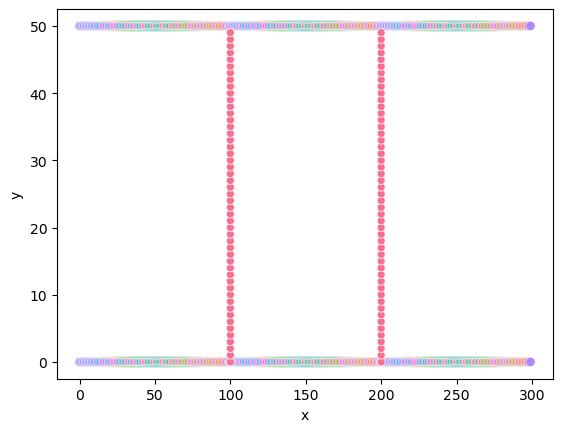

In [7]:
sns.scatterplot(circles_data, x="x", y="y", hue="colour_hex", size="r", legend=False)

# From high-dimensional data to a network
## Preamble
### Different graph formats
Depending on the tool that you want to use for _visualising_ the networks, you will need different formats.

In this notebook, we will always create nodes and links as arrays. For example:

`nodes` is an array of arrays. In case of the horse, containing `x`, `y`, and `z` values:
```
[[-1.06305e-02,  8.44801e-01,  4.67552e-01],
 [-2.40724e-02,  8.10356e-01,  4.72199e-01],
 [-1.80217e-03,  2.64261e-01, -5.05758e-01],
 [-3.20978e-02,  7.61185e-01,  3.15659e-01],
 [2.86350e-03,  7.25523e-01,  1.60297e-01]]
```

`links` is an array of 2D-arrays, containing the _source_ and _target_ node. That node is identified by its index in the `nodes` array, **starting from 0**:
```
[[0,1],[0,2],[1,2],[2,3]]
```

#### CSV
Let's start with the simplest output format: the nodes and links are stored in separate CSV files. You will need these, if you for example want to show your data in [gephi](http://www.gephi.org).

To export your data in 2 CSV files, it's easiest to create a Pandas dataframe for each first. In case of the horse data, we _already_ have it in that format, so we don't need to do anything:
```
horse_df.to_csv('nodes.csv', index=False)

links_df = pd.DataFrame(links, columns=["source","target"])
links_df.to_csv('links.csv', index=False)
```


#### D3-based format
For some other applications, we need a single JSON file containing nodes and links. It should look like this:

```
{ "nodes": [
    {"id": 0, "x":1, "y":2},
    {"id": 1, "x":3, "y":4},
    {"id": 2, "x":5, "y":6},
    {"id": 3, "x":7, "y":8}],
  "links": [
    {"source":0,"target":1},
    {"source":0,"target":2},
    {"source":1,"target":2},
    {"source":2,"target":3}]
}
```

Given that we have the structures that we described above, we can create the nodes as follows:
```
nodes_as_json = my_dataframe.to_dict(orient="records")
```

Similarly, to create the links:
```
links_as_json = [{'source': item[0], 'target': item[1]} for item in links]
```

To combine these in a single datastructure:
```
my_graph = {"nodes": nodes_as_json, "links": links_as_json}
```

And finally save them to a file
```
with open('my_graph.json', 'w') as f:
    json.dump(my_graph, f)
```

### Where are files saved?
You can find your saved file in Google colab if you click on the "folder" icon on the left.

In [8]:
# From Pandas data frame to graph nodes
horse_nodes = horse_data.to_dict(orient="records")
horse_nodes[:5]

[{'x': -0.0106305, 'y': 0.844801, 'z': 0.467552, 'id': 0},
 {'x': -0.0240724, 'y': 0.810356, 'z': 0.472199, 'id': 1},
 {'x': -0.00180217, 'y': 0.264261, 'z': -0.505758, 'id': 2},
 {'x': -0.0320978, 'y': 0.761185, 'z': 0.315659, 'id': 3},
 {'x': 0.0028635, 'y': 0.725523, 'z': 0.160297, 'id': 4}]

## kNN networks
A simple way to construct a network representation from a point cloud is to add edges between each node's k-nearest neighbours. The idea of this approach is that near neighbours better capture the local manifold of the data than just the distances. On the other hand, KNN networks lose density information, as all points will get the same number of edges in the network.

The code below constructs a KNN network on top of the data's minimum spanning tree and computes the correlation of the distances in the network with the point cloud distances.

In [9]:
horse_distances = pdist(horse_data)
horse_distance_matrix = squareform(horse_distances)

In [10]:
def create_knn_links(distance_matrix):
  k = 5
  knn_links = []

  for i in range(len(distance_matrix[0])):
      dist_i = distance_matrix[i]

      # Get the indices of the k nearest neighbors (excluding the point itself)
      nearest_indices = np.argsort(dist_i)[1:k+1]  # Exclude the point itself (index 0)

      for j in nearest_indices:
          knn_links.append([i,j,dist_i[j]])

  return knn_links

In [11]:
horse_knn_links = create_knn_links(horse_distance_matrix)

### Plotting using `networkx`
To draw the network, we can

1. export to 2 CSV files and upload in [gephi](www.gephi.org).
2. export as JSON file and use a custom tool (we won't do that here).
3. show the graph _within this notebook_, using `networkx`.

Below you can find the code to draw the graph using `networkx`. **CAUTION**, plots generated by `networkx` are generally good if the graphs are small (10-20 nodes). We're working with much larger data, so the result will be far from ideal.

In [12]:
def create_networkx(nodes, links):
  G = nx.Graph()

  for node in nodes:
    G.add_node(node["id"])

  for link in links:
    G.add_edge(link[0],link[1])

  return G

Now we can plot. The following code block may take some time...

In [15]:
def forceatlas2_layout(
    G,
    pos=None,
    *,
    max_iter=100,
    jitter_tolerance=1.0,
    scaling_ratio=2.0,
    gravity=1.0,
    distributed_action=False,
    strong_gravity=False,
    node_mass=None,
    node_size=None,
    weight=None,
    dissuade_hubs=False,
    linlog=False,
    seed=None,
    dim=2,
):
    """Position nodes using the ForceAtlas2 force-directed layout algorithm.

    This function applies the ForceAtlas2 layout algorithm [1]_ to a NetworkX graph,
    positioning the nodes in a way that visually represents the structure of the graph.
    The algorithm uses physical simulation to minimize the energy of the system,
    resulting in a more readable layout.

    Parameters
    ----------
    G : nx.Graph
        A NetworkX graph to be laid out.
    pos : dict or None, optional
        Initial positions of the nodes. If None, random initial positions are used.
    max_iter : int (default: 100)
        Number of iterations for the layout optimization.
    jitter_tolerance : float (default: 1.0)
        Controls the tolerance for adjusting the speed of layout generation.
    scaling_ratio : float (default: 2.0)
        Determines the scaling of attraction and repulsion forces.
    distributed_attraction : bool (default: False)
        Distributes the attraction force evenly among nodes.
    strong_gravity : bool (default: False)
        Applies a strong gravitational pull towards the center.
    node_mass : dict or None, optional
        Maps nodes to their masses, influencing the attraction to other nodes.
    node_size : dict or None, optional
        Maps nodes to their sizes, preventing crowding by creating a halo effect.
    dissuade_hubs : bool (default: False)
        Prevents the clustering of hub nodes.
    linlog : bool (default: False)
        Uses logarithmic attraction instead of linear.
    seed : int, RandomState instance or None  optional (default=None)
        Used only for the initial positions in the algorithm.
        Set the random state for deterministic node layouts.
        If int, `seed` is the seed used by the random number generator,
        if numpy.random.RandomState instance, `seed` is the random
        number generator,
        if None, the random number generator is the RandomState instance used
        by numpy.random.
    dim : int (default: 2)
        Sets the dimensions for the layout. Ignored if `pos` is provided.

    Examples
    --------
    >>> import networkx as nx
    >>> G = nx.florentine_families_graph()
    >>> pos = nx.forceatlas2_layout(G)
    >>> nx.draw(G, pos=pos)

    References
    ----------
    .. [1] Jacomy, M., Venturini, T., Heymann, S., & Bastian, M. (2014).
           ForceAtlas2, a continuous graph layout algorithm for handy network
           visualization designed for the Gephi software. PloS one, 9(6), e98679.
           https://doi.org/10.1371/journal.pone.0098679
    """
    import numpy as np

    if len(G) == 0:
        return {}
    # parse optional pos positions
    if pos is None:
        pos = nx.random_layout(G, dim=dim, seed=seed)
        pos_arr = np.array(list(pos.values()))
    else:
        # set default node interval within the initial pos values
        pos_init = np.array(list(pos.values()))
        max_pos = pos_init.max(axis=0)
        min_pos = pos_init.min(axis=0)
        dim = max_pos.size
        pos_arr = min_pos + seed.rand(len(G), dim) * (max_pos - min_pos)
        for idx, node in enumerate(G):
            if node in pos:
                pos_arr[idx] = pos[node].copy()

    mass = np.zeros(len(G))
    size = np.zeros(len(G))

    # Only adjust for size when the users specifies size other than default (1)
    adjust_sizes = False
    if node_size is None:
        node_size = {}
    else:
        adjust_sizes = True

    if node_mass is None:
        node_mass = {}

    for idx, node in enumerate(G):
        mass[idx] = node_mass.get(node, G.degree(node) + 1)
        size[idx] = node_size.get(node, 1)

    n = len(G)
    gravities = np.zeros((n, dim))
    attraction = np.zeros((n, dim))
    repulsion = np.zeros((n, dim))
    A = nx.to_numpy_array(G, weight=weight)

    def estimate_factor(n, swing, traction, speed, speed_efficiency, jitter_tolerance):
        """Computes the scaling factor for the force in the ForceAtlas2 layout algorithm.

        This   helper  function   adjusts   the  speed   and
        efficiency  of the  layout generation  based on  the
        current state of  the system, such as  the number of
        nodes, current swing, and traction forces.

        Parameters
        ----------
        n : int
            Number of nodes in the graph.
        swing : float
            The current swing, representing the oscillation of the nodes.
        traction : float
            The current traction force, representing the attraction between nodes.
        speed : float
            The current speed of the layout generation.
        speed_efficiency : float
            The efficiency of the current speed, influencing how fast the layout converges.
        jitter_tolerance : float
            The tolerance for jitter, affecting how much speed adjustment is allowed.

        Returns
        -------
        tuple
            A tuple containing the updated speed and speed efficiency.

        Notes
        -----
        This function is a part of the ForceAtlas2 layout algorithm and is used to dynamically adjust the
        layout parameters to achieve an optimal and stable visualization.

        """
        import numpy as np

        # estimate jitter
        opt_jitter = 0.05 * np.sqrt(n)
        min_jitter = np.sqrt(opt_jitter)
        max_jitter = 10
        min_speed_efficiency = 0.05

        other = min(max_jitter, opt_jitter * traction / n**2)
        jitter = jitter_tolerance * max(min_jitter, other)

        if swing / traction > 2.0:
            if speed_efficiency > min_speed_efficiency:
                speed_efficiency *= 0.5
            jitter = max(jitter, jitter_tolerance)
        if swing == 0:
            target_speed = np.inf
        else:
            target_speed = jitter * speed_efficiency * traction / swing

        if swing > jitter * traction:
            if speed_efficiency > min_speed_efficiency:
                speed_efficiency *= 0.7
        elif speed < 1000:
            speed_efficiency *= 1.3

        max_rise = 0.5
        speed = speed + min(target_speed - speed, max_rise * speed)
        return speed, speed_efficiency

    speed = 1
    speed_efficiency = 1
    swing = 1
    traction = 1
    for _ in range(max_iter):
        # compute pairwise difference
        diff = pos_arr[:, None] - pos_arr[None]
        # compute pairwise distance
        distance = np.linalg.norm(diff, axis=-1)

        # linear attraction
        if linlog:
            attraction = -np.log(1 + distance) / distance
            np.fill_diagonal(attraction, 0)
            attraction = np.einsum("ij, ij -> ij", attraction, A)
            attraction = np.einsum("ijk, ij -> ik", diff, attraction)

        else:
            attraction = -np.einsum("ijk, ij -> ik", diff, A)

        if distributed_action:
            attraction /= mass[:, None]

        # repulsion
        tmp = mass[:, None] @ mass[None]
        if adjust_sizes:
            distance += -size[:, None] - size[None]

        d2 = distance**2
        # remove self-interaction
        np.fill_diagonal(tmp, 0)
        np.fill_diagonal(d2, 1)
        factor = (tmp / d2) * scaling_ratio
        repulsion = np.einsum("ijk, ij -> ik", diff, factor)

        # gravity
        gravities = (
            -gravity
            * mass[:, None]
            * pos_arr
            / np.linalg.norm(pos_arr, axis=-1)[:, None]
        )

        if strong_gravity:
            gravities *= np.linalg.norm(pos_arr, axis=-1)[:, None]
        # total forces
        update = attraction + repulsion + gravities

        # compute total swing and traction
        swing += (mass * np.linalg.norm(pos_arr - update, axis=-1)).sum()
        traction += (0.5 * mass * np.linalg.norm(pos_arr + update, axis=-1)).sum()

        speed, speed_efficiency = estimate_factor(
            n,
            swing,
            traction,
            speed,
            speed_efficiency,
            jitter_tolerance,
        )

        # update pos
        if adjust_sizes:
            swinging = mass * np.linalg.norm(update, axis=-1)
            factor = 0.1 * speed / (1 + np.sqrt(speed * swinging))
            df = np.linalg.norm(update, axis=-1)
            factor = np.minimum(factor * df, 10.0 * np.ones(df.shape)) / df
        else:
            swinging = mass * np.linalg.norm(update, axis=-1)
            factor = speed / (1 + np.sqrt(speed * swinging))

        pos_arr += update * factor[:, None]
        if abs((update * factor[:, None]).sum()) < 1e-10:
            break

    return dict(zip(G, pos_arr))

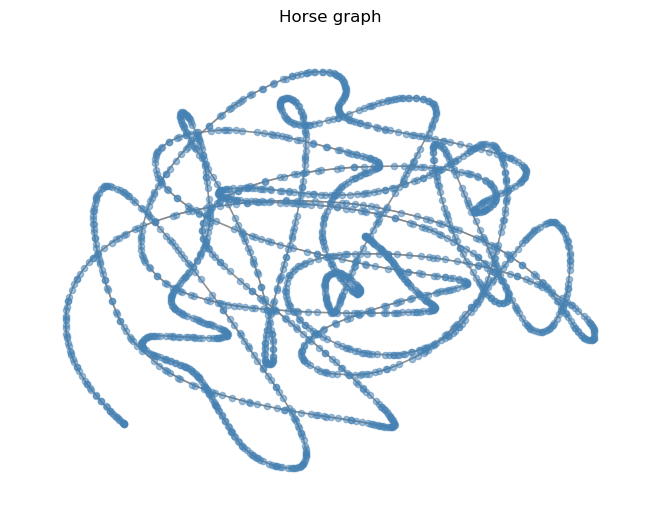

In [16]:
G = create_networkx(horse_nodes, horse_knn_links)
pos = forceatlas2_layout(G, max_iter=200)  # positions for all nodes
# pos = nx.arf_layout(G)
nx.draw(G, pos, node_color='steelblue', alpha=0.5, edge_color='gray', node_size=20)
plt.title('Horse graph')
plt.show()

### Plotting using a custom tool
NOTE: This is just for your reference; you won't have to do this yourself.

To convert our data into the D3 format and save it as a JSON file:

In [17]:
links_as_json = [{'source': int(item[0]), 'target': int(item[1])} for item in horse_knn_links]

In [18]:
horse_graph = {"nodes": horse_nodes, "links": links_as_json}

In [19]:
with open('horse_graph.json', 'w') as f:
    json.dump(horse_graph, f)

### Plotting using gephi
#### Installing/using gephi

Gephi can be downloaded from www.gephi.org.

To load a network, first load the **nodes** from a CSV file. In "File", click "**Import spreadsheet**". In the last step, choose "Undirected" for "Graph Type" and "New workspace".

To load the **edges**, again "File" and "Import spreadsheet". Here also choose "Undirected" for "Graph Type", but "**Append to existing workspace**" instead of "New workspace".

To draw the network, select the "**Choose a layout**" dropdown box on the left, and choose e.g. ForceAtlas2. Try out different layouts.

You can change the **size and colour of the nodes** (and links) on the top left. Choose "unique" if you want to give all nodes the same colour or size; choose "partition" if you have categories; choose "Ranking" if you want to use a numerical feature.

#### Creating the files for use in gephi
Gephi will need two CSV files.

In [20]:
horse_data.to_csv('nodes.csv', index=False)

df_links = pd.DataFrame(horse_knn_links, columns=["source","target","distance"])
df_links.to_csv('links.csv', index=False)

## Multi-MST networks
Here we generate small deviations from the original distance matrix, and calculate the MST (minimal spanning tree) on that altered matrix. At the end we add those MSTs together.

### Using the multi_mst package

In [21]:
from multi_mst.noisy_mst import NoisyMST

In [22]:
projector = NoisyMST(num_trees=10, noise_fraction=1.0).fit(horse_data)
coo_matrix = projector.graph_.tocoo()
sources = coo_matrix.row
targets = coo_matrix.col

/home/august-winderickx/miniconda3/envs/DR/lib/python3.11/site-packages/umap/umap_.py:2021: UserWarning: precomputed_knn[2] (knn_search_index) is not an NNDescent object: transforming new data with transform will be unavailable.
  warn(


In [23]:
sources[:5]

array([0, 0, 1, 1, 1], dtype=int32)

In [24]:
targets[:5]

array([1, 2, 0, 2, 3], dtype=int32)

In [25]:
links = [[s, t] for s, t in zip(sources, targets)]

In [26]:
links[:5]

[[0, 1], [0, 2], [1, 0], [1, 2], [1, 3]]

Write the code necessary to
1. convert the `links` array into a dataframe
2. save those links in a CSV file
3. save the nodes in a CSV file

In [27]:
# Convert the `links` array into a dataframe
links_df = pd.DataFrame(links, columns=["source", "target"])

# Save the links in a CSV file
links_df.to_csv('links.csv', index=False)

# Save the nodes in a CSV file
circles_data.to_csv('nodes.csv', index=False)# YOUR CODE HERE

### Coding this ourselves
We can do a similar thing without using the `multi-mst` package.

In [28]:
distances = []
def alter_distances(distances, max_amount = np.std(distances)/50):
    changer = lambda t: t + random.uniform(0, max_amount)
    return np.array([changer(d) for d in distances])

/home/august-winderickx/miniconda3/envs/DR/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/august-winderickx/miniconda3/envs/DR/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/august-winderickx/miniconda3/envs/DR/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
def calculate_mst(distances):
    X = csr_matrix(squareform(distances))
    mst = minimum_spanning_tree(X)
    return np.nonzero(mst)

In [30]:
def add_mst_to_links(links, mst):
    for i in range(0,len(mst[0])):
        # links.append('{"source":' + str(mst[0][i]) + ', "target":' + str(mst[1][i]) + '}')
        links.append([mst[0][i], mst[1][i]])
    return links

In [31]:
links = []

for i in range(10):
    print(i)
    flow(
        horse_distances,
        lambda d: alter_distances(d, max_amount = np.std(horse_distances)),
        lambda d: calculate_mst(d),
        lambda d: add_mst_to_links(links,d)
    )

0
1
2
3
4
5
6
7
8
9


Let's see what this looks like in gephi: export as CSVs and load in gephi.

In [32]:
horse_data.to_csv('nodes.csv', index=False)

links_df = pd.DataFrame(links, columns=["source","target"])
links_df.to_csv('links.csv', index=False)

## Mapper network
The mapper networks are fundamentally different from the ones above (see the lecture). Each node in the resulting graph is a _cluster_ of datapoints, not single datapoints.

In spatial domains, topological data analysis is typically used to analyze a signal on a regular grid. For instance, the colour of pixels on an image, or the density of tissue in an CT scan. In these cases, the pixels or voxels provide a notion of connectedness, i.e., pixels that are adjacent to each other are connected. As a result, persistent features can be computed over the signal's values instead of the distance between samples.

For point clouds, this is more difficult, because they do not have an inherrent notion of connectivity. Suppose we perform a filtration over some function $f(v)$, that returns a single value for each data point in a point cloud. Then, instead of edges being included in the simplicial complex as the distance threshold increases, now data points are added to the simplicial complex as the threshold on $f$ increases. But how are these data-points connected? Without that information, we cannot compute the topological features.

The [Mapper](http://diglib.eg.org/bitstream/handle/10.2312/SPBG.SPBG07.091-100/091-100.pdf?sequence=1&isAllowed=y) algorithm provides a solution to this problem. It is able to analyzing a signal on point-cloud data. The algorithm works by (a) defining overlapping segments over a lens (or filter), i.e. the signal of interest. Then, (b) it clusters the data points within each segment. Mapper does not impose any restrictions on which clustering algorithm can be used. The resulting clustering provides the notion of connectivity, it determines which data points in each segment belong together. The clusters become nodes in the resulting mapper graph. Note, though, that the distance threshold which determines which data points belong to a cluster can vary between the lens's segments! Finally, (c) Edges between these nodes are added based on data point overlap between the nodes. There can be overlap because the segments of the lens have overlap.

![Mapper overview](https://gist.githubusercontent.com/JelmerBot/37568240a38c39bf39f20302ed8a130f/raw/9a79ff6e0a2f2c8b79714e5aa4830d99be63a0aa/mapper.png)

The code below computes and visualizes a mapper network for the horse data set. You can play around with the n_intervals and overlap_frac parameters to change the resultion of segments. You can also change columns of the projection to determine which columns are used as filter. Using more than one column tends to work best for the horse, but in general we do not know in advance which filters produce interesting results! Also check what happens when you do not normalize the input data!

In [34]:
from gtda.mapper import make_mapper_pipeline
from gtda.mapper.filter import Projection
from gtda.mapper.cover import CubicalCover, OneDimensionalCover
from gtda.mapper import plot_static_mapper_graph
from sklearn.preprocessing import StandardScaler
from gtda.mapper.cluster import FirstSimpleGap, FirstHistogramGap

# Normalize dimensions with z-score (mean 0 std 1).
# The x-dimension is small compared to y and z, so the clustering
# does not separate the front-legs and back-legs. By scaling, we
# emphazise patterns in dimensions with small values.
scaler=StandardScaler()

# Define filter function – can be any scikit-learn transformer
# The `Projection` class is named confusingly. It does not
# project the data, it simply returns the specified columns of
# the data. Mapper can deal with more than 1 filter dimension!
filter_func=Projection(columns=[1])

# Define cover, i.e. the segments over the filters.
# Here you can specify the number of segments and their overlap
# ratio.
# cover=OneDimensionalCover(n_intervals=11, overlap_frac=0.2)

cover=OneDimensionalCover(n_intervals=11, overlap_frac=0.2)

# Choose clustering algorithm
clusterer=FirstSimpleGap()

# Initialise pipeline
pipe = make_mapper_pipeline(
    clustering_preprocessing=scaler,
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=-1,
)

# Compute the mapper network and visualize it
fig = plot_static_mapper_graph(
    pipe, horse_data.to_numpy(), color_data=horse_data[['y', 'z', 'x']]
)
fig.show(config={'scrollZoom': True})

Have a look at the `gtda.mapper` documentation at https://giotto-ai.github.io/gtda-docs/0.3.1/modules/mapper.html to see what you can change in the code above.

If you use `cover=OneDimensionalCover(n_intervals=11, overlap_frac=0.2)`, can you interpret the picture that comes out?

It can difficult to interpret a Mapper network because we do not have control over the clustering. Sometimes we want to increase or reduce the clustering threshold to show more or less nodes per segment. In addition, which filters are used (either dimensions of the data or functions based on the point cloud) also has a large effect on the resulting network.

## Using a lens
Let's have a look if we add a lens to our network.

First, create a multi-MST graph for the `circles_data` dataset. We only want to do that using the `x` and `y` columns, so first need to create a different dataset with just those.

In [35]:
circles_data_xy = circles_data.drop(["r","colour","id","colour_hex"], axis=1)
circles_data_xy

,x,y
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
1395,200,47
1396,200,48
1397,200,48
1398,200,49


In [36]:
circles_nodes = circles_data.to_dict(orient="records")

In [37]:
circles_distances = pdist(circles_data_xy)
circles_distance_matrix = squareform(circles_distances)

In [38]:
links = []

for i in range(20):
    print(i)
    flow(
        circles_distances,
        lambda d: alter_distances(d, max_amount = np.std(circles_distances)),
        lambda d: calculate_mst(d),
        lambda d: add_mst_to_links(links,d)
    )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [39]:
circles_data.to_csv('nodes.csv', index=False)

links_df = pd.DataFrame(links, columns=["source","target"])
links_df.to_csv('links.csv', index=False)

If we load this data in gephi, we get the following picture:

<img src="https://aida-lab.pages.gitlab.kuleuven.be/assets/circles_lens_none.png" alt="circles without lens" height="300" />

### Implementing a lens
A very simple way to create a lens _post-hoc_, is to remove links that should not be there.

For example, the size of the datapoints ranges from 0 to 100. We can remove all links where the difference in node size is larger than 20.

We will go through all links, get the nodes, get their sizes and compare them.

In [40]:
max_difference = 30
filtered_links = [
    link for link in links
    if abs(circles_nodes[link[0]]['colour'] - circles_nodes[link[1]]['colour']) <= max_difference
]

In [41]:
print(len(links))
print(len(filtered_links))

27980
19000


In [42]:
links_df = pd.DataFrame(filtered_links, columns=["source","target"])
links_df.to_csv('filtered_links_colour.csv', index=False)

This is the image that we now get from gephi. You clearly see that there is something else going on that you didn't see in the image at the top of this notebook (i.e. where we just plotted `x` and `y`).

<img src="https://aida-lab.pages.gitlab.kuleuven.be/assets/circles_lens_colour.png" alt="circles with colour lens" height="300" />

# Persistent homology

As explained in the lecture, persistent homology analyzes topological features at multiple scales and determines which features persist across a larger range of these scales. A typical way to compute persistent topological features for point clouds are *Vietoris-Rips complexes*. In 2D, this process can be thought of as spheres covering each data point and introducing an edge when spheres start to overlap as their radius increases. Cliques in the resulting network form *simplices*: edges, triangles, tetrahedrons, and their higher dimensional equivalents. Together, the simplices at a single radius form a *simplicial complex* and the sequence of simplicial complexes over the scale form a *filtration*.

![Vietoris-Rips filtration](https://giotto-ai.github.io/gtda-docs/latest/_images/vietoris_rips_point_cloud.gif)

[Image from the Giotto TDA website](https://giotto-ai.github.io/gtda-docs/latest/notebooks/persistent_homology_graphs.html)

The topological features that we are interested in can be computed from the *simplicial complexes* of a *filtration*. Typically, these topological features correspond to [Betti numbers](https://en.wikipedia.org/wiki/Betti_number) and capture the number of connected components (dimension 0), the number of loops (dimension 1), and number of voids (dimension 2 and higher). Using the filtration, we determine when each feature starts to occur and when it dies. For example, looking at the animation above, you can see at which distance the circle closes, and when it dies because it gets filled in with triangles. The difference between a feature's death and birth is their *persistence*. Generally, we assume that are a few features that are more persistent than the others. These features are interpreted to capture the true underlying shape of the point cloud, while the others are attributed to noise.

Note that 0-dimensional persistence diagrams are closely related to single-linkage hierarchical clustering dendrograms. Both constructs describe at which distances certain data-points belong 'together'. Their difference is in their interpretation of a merge. Suppose that there are two connected components, or clusters, that merge at distance some $d$. The dendrogram interprets this merge to mean that both clusters combine and continue to exist as a single entity. The persistence diagram instead sees the merge as the death of one of the components while the other continues to exist.

## Persistent features of a torus

In this example, we show how to use Giotto-TDA to compute the persistence diagram of a point cloud, in this case a torus.

First, we have to construct the point cloud:

In [43]:
from gtda.plotting import plot_point_cloud

def make_torus(inner_radius = 1, outer_radius = 2, num_samples = 512):
  s = np.random.rand(num_samples) * np.pi * 2
  t = np.random.rand(num_samples) * np.pi * 2
  return np.column_stack([
    (outer_radius+inner_radius*np.cos(s))*np.cos(t),
    (outer_radius+inner_radius*np.cos(s))*np.sin(t),
    inner_radius * np.sin(s)
  ])

torus = make_torus()
plot_point_cloud(torus)

Now we can use Giotto-TDA to compute the persistent features in the first three dimensions. We use a `WeakAlphaPersistence` filtration to speed up the computation. This filtration computes a Vietoris-Rips complex using only the edges in a Delaunay triangulation, which is efficient to create for low-dimensional datasets.

Giotto-TDA is designed with machine learning in mind. It expects the input the be a training-set of point-clouds. We, however, only use a single point cloud at the moment. So, we have to pass a list as input `[torus]` and then look at the first diagram in the output `diagrams[0]`. Note how we specify which dimensions should be computed and that we set `reduced_homology = False`. This latter argument makes Giotto-TDA return the infinitly persistent 0-dimensional simplex. Otherwise, it would have been silently removed.

In the resulting output, we clearly see the persistent features of a torus: one 0-dimensionional component, two 1-dimensional loops, one 2-dimensional void.



In [44]:
from gtda.plotting import plot_diagram
from gtda.homology import WeakAlphaPersistence

WA = WeakAlphaPersistence(homology_dimensions=[0, 1, 2],
                          reduced_homology=False,
                          n_jobs=-1)
diagrams = WA.fit_transform([torus])

plot_diagram(diagrams[0])

Another way to view a persistence diagrams is as a barcode, where each bar represents a topological feature and indicates when the feature started to exist and when it died. The code below constructs barcodes for the torus.

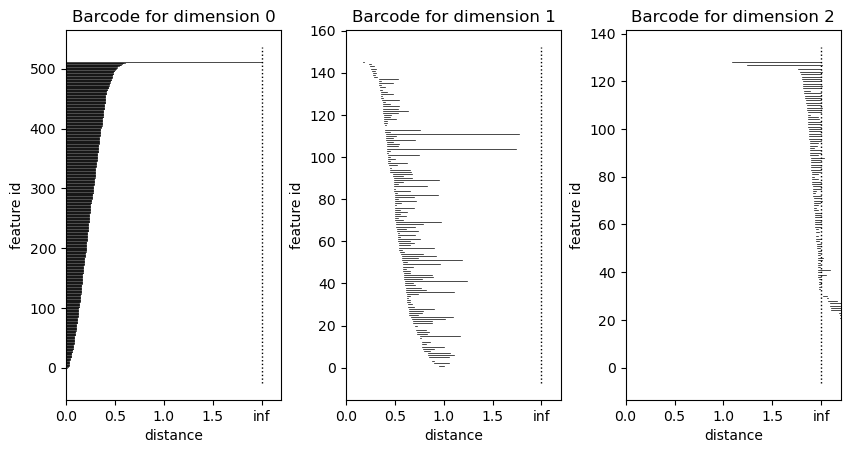

In [45]:
ds = [0, 1, 2]
inf_value = 2
for i, d in enumerate(ds):
  plt.subplot(1, len(ds), i+1)
  components = diagrams[0][diagrams[0][:, 2] == d]
  for i, pair in enumerate(components):
    plt.plot([pair[0], pair[1] if not np.isinf(pair[1]) else inf_value], [i, i], 'k-', linewidth=0.5)
  plt.title(f'Barcode for dimension {d}')
  plt.xlabel('distance')
  plt.ylabel('feature id')
  plt.xlim([0, 2.2])

  plt.plot([inf_value, inf_value], plt.ylim(), 'k:', linewidth=1)
  ticks = np.linspace(0, inf_value, 5)
  labels = [
    f'{t}' if t != inf_value else 'inf'
    for t in ticks
  ]
  plt.gca().set_xticks(ticks)
  plt.gca().set_xticklabels(labels)

plt.subplots_adjust(wspace=0.3)
plt.gcf().set_figwidth(10)
plt.show()

## Persistent features of the horse

Using the example above, compute a the persistence diagram for the horse. How many 0, 1, and 2 dimensional features does the horse have? Can you describe how each feature corresponds the horse's shape?

In [46]:
plot_point_cloud(horse_data.to_numpy())

In [47]:
# Compute the horse's persistent features here
diagrams_horse = WA.fit_transform([horse_data[['x', 'y', 'z']].to_numpy()])
plot_diagram(diagrams_horse[0])

As expected there is a single persistent 0-dimensional component. There are no clearly persistent loops, but there is one persistent void.

## Persistent features of the circles dataset
Now do the same thing for the circles data. You will want to use `circles_data_xy` instead of `circles_data` because the latter contains non-numeric data.

In [51]:
# Remove any NaN values from the circles_data_xy dataset
circles_data_xy_clean = circles_data_xy.dropna().reset_index(drop=True)

# Compute the persistent features for the circles dataset
diagrams_circles = WA.fit_transform([circles_data_xy_clean[:-1].to_numpy()])

# Plot the persistence diagram
plot_diagram(diagrams_circles[0])